In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

# CSEDM Data Case study
base: uirt_lfa_model_csedm_final.ipynb

## Read in and preprocess data

In [2]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import time
import os
from os import path
import sys
sys.path.append(os.path.realpath("./models"))
sys.path.append(os.path.realpath("./em_algorithm"))
# Custom modules, import violates pep8, so we have to declare an exeption
if True:  # noqa: E402
    from mirt_2pl import mirt_2pl
    from mirt_2pl_gain import mirt_2pl_gain
    from e_step_mirt_2pl import e_step_ga_mml
    from e_step_mirt_2pl_gain import e_step_ga_mml_gain
    from m_step_mirt_2pl import m_step_ga_mml
    from m_step_mirt_2pl_gain import m_step_ga_mml_gain
    from em_algorithm import em_algo

In [6]:
semester = 'F19'
BASE_PATH = os.path.join('path_to_dataset/csedm_challenge_dataset', 'F19_Release_Train_06-28-21')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')

In [7]:
#Dataset for early Problem Performance (Aggregated from Event-Data)
early = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early["alt_Label"] = early.apply(lambda x: 1 if (x["CorrectEventually"] and x["Attempts"] <= 3) else 0, axis=1)
early

late = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))

In [8]:
from sklearn.impute import KNNImputer

#Obtain Matrix of Response-vectors
U = pd.crosstab(index = early["SubjectID"], 
            columns=[early["AssignmentID"], early["ProblemID"]], 
            values=early["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
imputer = KNNImputer(n_neighbors=4)
U = imputer.fit_transform(U).round()
U = pd.DataFrame(U)

#Obtain Matrix of Response-vectors
V = pd.crosstab(index = late["SubjectID"], 
            columns=[late["AssignmentID"], late["ProblemID"]], 
            values=late["Label"],
            aggfunc="sum")
#At the moment we will delete missing values row-wise. It will be usefull to impute values later, since missing at random is unlikely
#late_U = late_U.dropna()

imputer = KNNImputer(n_neighbors=4)
V = imputer.fit_transform(V).round()
V = pd.DataFrame(V)


In [9]:
V

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
363,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
364,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
365,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
#Source: https://docs.google.com/spreadsheets/d/1-APxPAVP3PylM0fskzDNgpalj1DTuMqDLkgBC5QxJdg/edit#gid=0
item_skill_df = pd.read_csv("CSEDM Challenge/item_skill_relation.csv")
item_skill_df.columns

Index(['AssignmentID', 'ProblemID', 'Requirement', 'If/Else', 'NestedIf',
       'While', 'For', 'NestedFor', 'Math+-*/', 'Math%', 'LogicAndNotOr',
       'LogicCompareNum', 'LogicBoolean', 'StringFormat', 'StringConcat',
       'StringIndex', 'StringLen', 'StringEqual', 'CharEqual', 'ArrayIndex',
       'DefFunction'],
      dtype='object')

In [11]:
logic_skills = ['If/Else', 'NestedIf', 'LogicAndNotOr', 'LogicCompareNum', 'LogicBoolean']
string_skills = ['StringFormat', 'StringConcat', 'StringIndex', 'StringLen', 'StringEqual', 'CharEqual']
iter_skills = ['While', 'For', 'NestedFor', 'ArrayIndex']

logic_exercises = (np.sum(item_skill_df[logic_skills], axis=1) > 0)
string_exersises = (np.sum(item_skill_df[string_skills], axis=1) > 0)
iter_exercises = (np.sum(item_skill_df[iter_skills], axis=1) > 0)

full_Q = np.stack((logic_exercises, iter_exercises), axis=1)
early_Q = full_Q[0:30,:]
late_Q = full_Q[30:50, :]
# Ensure Identification
late_Q[2,1] = False

In [12]:
late_Q

array([[False,  True],
       [ True,  True],
       [ True, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False,  True],
       [False,  True]])

### Fit Model

In [13]:
import random
random.seed(100)
np.random.seed(100)

In [14]:
# Fit early Model
early_model = mirt_2pl(latent_dimension=2, item_dimension=U.shape[1], Q=early_Q)
early_model.initialize_from_responses(response_data=U)
e_step = e_step_ga_mml(model=early_model)
m_step = m_step_ga_mml(
    early_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=early_model)


start_time = time.time()
em.fit([U.reset_index(drop=True)], max_iter=30,
        stop_threshold=0.001, person_method="BFGS")
run_time = (time.time() - start_time)
theta_hat = early_model.predict_competency(U)
estimated_early_item_parameters = em.model.item_parameters
estimated_early_person_parameters = em.model.person_parameters

EM Iteration 2


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 300
[[1.     0.3948]
 [0.3948 0.9999]]
Step: 2: current parameter_diff: 7.123144369817095, current marginal loglikelihood: -5613.442061953425
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[1.     0.3537]
 [0.3537 1.    ]]
Step: 3: current parameter_diff: 3.725735565101794, current marginal loglikelihood: -5599.26968885875
EM Iteration 4
Current Monte Carlo Sample size: 324
[[0.9999 0.3098]
 [0.3098 1.    ]]
Step: 4: current parameter_diff: 3.638039734747279, current marginal loglikelihood: -5586.116490732511
EM Iteration 5
Current Monte Carlo Sample size: 349
[[1.     0.2839]
 [0.2839 1.    ]]
Step: 5: current parameter_diff: 2.258091755157589, current marginal loglikelihood: -5582.862166434623
EM Iteration 6


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[0.9999 0.2917]
 [0.2917 1.    ]]
Step: 6: current parameter_diff: 1.0753392824248909, current marginal loglikelihood: -5579.15852880436
EM Iteration 7
Current Monte Carlo Sample size: 349
[[1.     0.3025]
 [0.3025 1.    ]]
Step: 7: current parameter_diff: 0.7062163531582382, current marginal loglikelihood: -5584.9940014358435
EM Iteration 8
Current Monte Carlo Sample size: 349
[[1.     0.3094]
 [0.3094 1.    ]]
Step: 8: current parameter_diff: 0.8665951325205431, current marginal loglikelihood: -5580.383059828765
EM Iteration 9
Current Monte Carlo Sample size: 349
[[1.     0.2795]
 [0.2795 1.    ]]
Step: 9: current parameter_diff: 0.43904620265697614, current marginal loglikelihood: -5580.214142885234
EM Iteration 10
Current Monte Carlo Sample size: 349
[[0.9999 0.2841]
 [0.2841 0.9999]]
Step: 10: current parameter_diff: 1.3276140805840662, current marginal loglikelihood: -5574.9397713595


In [15]:
p_early = np.mean(U, axis=1)
p_late = np.mean(V, axis=1)
# Correct numerical problems with the inverse logistic function
p_early[p_early == 0] = np.min(p_early[p_early != 0])
p_early[p_early == 1] = np.max(p_early[p_early != 1])
p_late[p_late == 0] = np.min(p_late[p_late != 0])
p_late[p_late == 1] = np.max(p_late[p_late != 1])
# get logits
logit_early = np.log(np.divide(p_early, 1 -
                                p_early))
logit_late = np.log(np.divide(p_late, 1 -
                                p_late))
var_logit_early = np.var(logit_early)
var_logit_late = np.var(logit_late)

#
print("Early logit variance: {0}".format(var_logit_early))
print("Late logit variance: {0}".format(var_logit_late))
print("Approximate summation variance: {0}".format(var_logit_late/var_logit_early))

Early logit variance: 1.2907867467786318
Late logit variance: 1.790658381505874
Approximate summation variance: 1.3872612079220314


In [16]:
#Fit late Model
# Initialize Model
late_model = mirt_2pl_gain(item_dimension=20, latent_dimension=2, mu=np.zeros(2),
                            early_sigma=estimated_early_person_parameters["covariance"],
                            Q=late_Q)
# TODO: Check if theta_hat can be used
late_model.initialize_from_responses(
    late_response_data=V, early_response_data=U,
    convolution_variance=np.ones(2)*var_logit_late/var_logit_early,
    sigma=False)
late_initial_parameters = late_model.get_parameters()
e_step = e_step_ga_mml_gain(
    model=late_model, convolution_factor=20, gamma=1.5)
m_step = m_step_ga_mml_gain(
    late_model, sigma_constraint="early_constraint")
em = em_algo(e_step=e_step, m_step=m_step, model=late_model)

# Fit late model
start_time = time.time()
em.fit([V, pd.DataFrame(theta_hat)], max_iter=30,
        stop_threshold=0.005, person_method="BFGS")
run_time = (time.time() - start_time)
s_hat = late_model.predict_gain(
    V, pd.DataFrame(theta_hat))

s_pred_train = late_model.predict_gain(
    theta=pd.DataFrame(theta_hat))


EM Iteration 2
Current Monte Carlo Sample size: 300
[[0.9999 0.2841 0.1303 0.0763]
 [0.2841 0.9999 0.0727 0.1302]
 [0.1303 0.0727 0.3484 0.1035]
 [0.0763 0.1302 0.1035 0.3393]]
Step: 2: current parameter_diff: 16.876094476988214, current marginal loglikelihood: -4293.1824504578635
EM Iteration 3


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 324
[[0.9999 0.2841 0.1338 0.0739]
 [0.2841 0.9999 0.0702 0.1393]
 [0.1338 0.0702 0.3553 0.1025]
 [0.0739 0.1393 0.1025 0.345 ]]
Step: 3: current parameter_diff: 6.883042924705552, current marginal loglikelihood: -4271.056041684078
EM Iteration 4


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 349
[[0.9999 0.2841 0.1336 0.0723]
 [0.2841 0.9999 0.0697 0.1364]
 [0.1336 0.0697 0.3554 0.0998]
 [0.0723 0.1364 0.0998 0.3474]]
Step: 4: current parameter_diff: 2.840741457142374, current marginal loglikelihood: -4255.037156020615
EM Iteration 5


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 376
[[0.9999 0.2841 0.132  0.0719]
 [0.2841 0.9999 0.073  0.1381]
 [0.132  0.073  0.3581 0.1028]
 [0.0719 0.1381 0.1028 0.3456]]
Step: 5: current parameter_diff: 3.9761194069755814, current marginal loglikelihood: -4243.3974919623215
EM Iteration 6


c:\Users\Jesper\anaconda3\lib\site-packages\scipy\stats\_qmc.py:2039: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples = self.engine.random(n)


Current Monte Carlo Sample size: 406
[[0.9999 0.2841 0.1299 0.0713]
 [0.2841 0.9999 0.0746 0.1369]
 [0.1299 0.0746 0.3637 0.107 ]
 [0.0713 0.1369 0.107  0.3478]]
Step: 6: current parameter_diff: 1.221869340307339, current marginal loglikelihood: -4241.188728135961


### Postprocess

#### Item Parameters

In [17]:
#Item Parameters 

# Early 
early_A = early_model.item_parameters["discrimination_matrix"]
early_delta = early_model.item_parameters["intercept_vector"]
early_Q = early_model.item_parameters["q_matrix"]

# Late
late_A = late_model.item_parameters["discrimination_matrix"]
late_delta = late_model.item_parameters["intercept_vector"]
late_Q = late_model.item_parameters["q_matrix"]

In [18]:
def rel_test_difficulty(A, delta):
    rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)
    rel_item_difficulty[np.isinf(rel_item_difficulty)] = np.nan
    rel_test_difficulty = np.nanmedian(rel_item_difficulty, axis=0)
    return(rel_test_difficulty)


def shift_table(s_hat, A, delta, early_reldiff):
    quantiles = np.arange(0, 0.5, 0.01)
    perc_pos_logic =[]
    perc_pos_iter = []
    logic_reldiff = []
    iter_reldiff = []
    for quantile in quantiles:
        shift = -1*np.quantile(s_hat, q=quantile, axis=0)
        delta_shift = late_delta - np.dot(late_A, shift)
        s_shift = s_hat + shift
        perc_positive = np.divide(np.sum(s_shift >= 0, axis=0), np.sum(s_shift == s_shift, axis=0))
        perc_pos_logic.append(perc_positive[0])
        perc_pos_iter.append(perc_positive[1])
        rel_test_diff = rel_test_difficulty(A=A, delta=delta_shift)
        logic_reldiff.append(rel_test_diff[0])
        iter_reldiff.append(rel_test_diff[1])
# Create two subplots and unpack the output array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(9)
    f.tight_layout(pad=1.5)
    #f.suptitle("Share of students with Competency \n Gain vs. Relative Test Difficulty", fontsize=14, y=1.05)
    ax1.plot(perc_pos_logic, logic_reldiff)
    ax1.plot(perc_pos_logic, [early_reldiff[0] for i in range(0, len(perc_pos_iter))])
    ax1.set_title("Logic Competency")
    ax2.plot(perc_pos_iter, iter_reldiff)
    ax2.plot(perc_pos_iter, [early_reldiff[1] for i in range(0, len(perc_pos_iter))])
    ax2.set_title("Iteration Competency")
    ax1.set_ylabel("Relative Difficulty", fontsize=12)
    ax1.set_xlabel("Proportion of positive change (gain)", fontsize=11)
    ax2.set_xlabel("Proportion of positive change (gain)", fontsize=11)
    plt.legend(["Late Difficulty", "Early Difficulty"], fontsize=11)
    #f.title("Share of students with Competency \n Gain vs. Relative Test Difficulty")

C:\Users\Jesper\AppData\Local\Temp\ipykernel_17736\1637136352.py:2: RuntimeWarning: divide by zero encountered in true_divide
  rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)


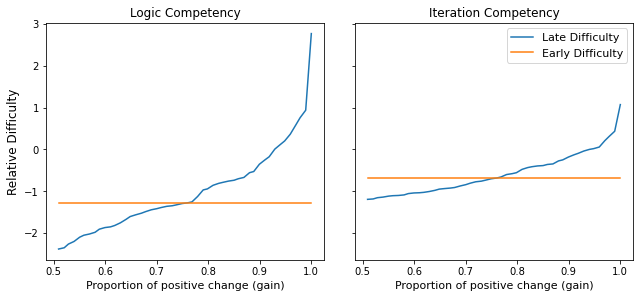

In [19]:
early_reldiff = rel_test_difficulty(A=early_A, delta=early_delta)
shift_table(s_hat=s_hat, A=late_A, delta=late_delta, early_reldiff=early_reldiff)
plt.savefig("results/plots/csedm_reldiff_vs_shift", dpi=250)

In [80]:
rel_test_difficulty(A=early_A, delta=early_delta)

C:\Users\Gerha\AppData\Local\Temp\ipykernel_11312\1158090350.py:2: RuntimeWarning: divide by zero encountered in divide
  rel_item_difficulty = np.divide(np.expand_dims(-delta, 1), A)


array([-1.19815747, -0.6331392 ])

In [20]:
shift = np.zeros(2)
#Logic shift
shift[0] = -1*np.quantile(s_hat[:,0], q=0.15, axis=0)
#Iteration shift
shift[1] = -1*np.quantile(s_hat[:,1], q=0.05, axis=0)
s_hat_shift = s_hat + shift
mu_shift = late_model.person_parameters["mean"][2:4] + shift
late_delta_shift = late_delta - np.dot(late_A, shift)

In [21]:
#Check shift results
np.divide(np.sum(s_hat_shift >= 0, axis=0), np.sum(s_hat_shift == s_hat_shift, axis=0))

array([0.85013624, 0.94822888])

## Report Item Parameters

In [22]:
def item_parameter_table(A, Q, delta, latent_description=["Logic", "Iteration"], caption="", n=367):
    data = pd.DataFrame(np.concatenate((Q, A), axis=1))
    data.columns = pd.MultiIndex.from_product([['Q', 'A'], latent_description],
                                     names=['Param.', 'Latent dim.'])
    delta_df = pd.DataFrame(np.expand_dims(delta, 1), columns=[("$\Delta$", "")])
    data = pd.concat((data, delta_df), axis=1)
    data = np.round(data, 3)
    print(data.to_latex(bold_rows=True, multicolumn=True, 
                                   caption=caption+", n={0}".format(n), 
                                   position="H", escape=False))
    return(data)

In [23]:
item_parameter_table(A=early_A, Q=early_Q, delta=early_delta, caption="CSEDM: Early Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Early Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   1.0 &       0.0 &  0.834 &     0.000 &    1.637 \\
\textbf{1 } &   1.0 &       0.0 &  1.201 &     0.000 &    1.333 \\
\textbf{2 } &   1.0 &       0.0 &  0.877 &     0.000 &    1.268 \\
\textbf{3 } &   1.0 &       0.0 &  0.761 &     0.000 &    1.343 \\
\textbf{4 } &   1.0 &       0.0 &  1.182 &     0.000 &    1.407 \\
\textbf{5 } &   1.0 &       0.0 &  1.419 &     0.000 &    1.518 \\
\textbf{6 } &   1.0 &       0.0 &  0.973 &     0.000 &    1.128 \\
\textbf{7 } &   1.0 &       0.0 &  0.877 &     0.000 &    1.324 \\
\textbf{8 } &   1.0 &       0.0 &  0.953 &     0.000 &    1.170 \\
\textbf{9 } &   1.0 &       0.0 &  1.361 &     0.000 &    1.304 \\
\textbf{10} &   1.0 &       0.0 &  1.119 &     0.00

C:\Users\Jesper\AppData\Local\Temp\ipykernel_17736\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             1.0       0.0  0.834     0.000    1.637
1             1.0       0.0  1.201     0.000    1.333
2             1.0       0.0  0.877     0.000    1.268
3             1.0       0.0  0.761     0.000    1.343
4             1.0       0.0  1.182     0.000    1.407
5             1.0       0.0  1.419     0.000    1.518
6             1.0       0.0  0.973     0.000    1.128
7             1.0       0.0  0.877     0.000    1.324
8             1.0       0.0  0.953     0.000    1.170
9             1.0       0.0  1.361     0.000    1.304
10            1.0       0.0  1.119     0.000    1.510
11            1.0       0.0  1.157     0.000    1.586
12            1.0       0.0  1.209     0.000    1.543
13            1.0       0.0  1.324     0.000    1.470
14            1.0       0.0  1.063     0.000    1.184
15            1.0       0.0  1.164     0.000    0.803
16            1.0       0.0  1.165     0.000    1.255
17            1.0       0.0  1.008     0.000    1.236
18            1.0       1.0  1.000     0.628    0.370
19            1.0       0.0  0.857     0.000    0.625
20            0.0       1.0  0.000     2.499    1.620
21            1.0       1.0  0.106     2.511    1.352
22            1.0       1.0  0.332     1.744    1.198
23            1.0       1.0  0.214     1.658    1.117
24            1.0       1.0  0.867     1.231    1.554
25            1.0       0.0  0.788     0.000    1.135
26            1.0       1.0  0.483     1.167    0.639
27            1.0       1.0  0.834     1.212    1.243
28            1.0       1.0  0.720     0.828    0.924
29            1.0       1.0  0.697     1.532    1.032

In [24]:
item_parameter_table(A=late_A, Q=late_Q, delta=late_delta_shift, caption="CSEDM: Late Item Parameters")

\begin{table}[H]
\centering
\caption{CSEDM: Late Item Parameters, n=367}
\begin{tabular}{lrrrrr}
\toprule
\textbf{Param.} & \multicolumn{2}{l}{Q} & \multicolumn{2}{l}{A} & $\Delta$ \\
\textbf{Latent dim.} & Logic & Iteration &  Logic & \multicolumn{2}{l}{Iteration} \\
\midrule
\textbf{0 } &   0.0 &       1.0 &  0.000 &     0.444 &    0.981 \\
\textbf{1 } &   1.0 &       1.0 &  1.071 &     0.810 &    0.432 \\
\textbf{2 } &   1.0 &       0.0 &  1.245 &     0.000 &    1.533 \\
\textbf{3 } &   1.0 &       1.0 &  0.980 &     1.467 &   -0.126 \\
\textbf{4 } &   1.0 &       1.0 &  1.162 &     0.566 &    0.350 \\
\textbf{5 } &   1.0 &       1.0 &  0.599 &     0.813 &    0.163 \\
\textbf{6 } &   1.0 &       1.0 &  0.829 &     0.803 &    0.061 \\
\textbf{7 } &   1.0 &       1.0 &  0.252 &     1.232 &    0.202 \\
\textbf{8 } &   1.0 &       1.0 &  0.806 &     2.338 &   -0.661 \\
\textbf{9 } &   1.0 &       1.0 &  0.014 &     1.608 &   -0.826 \\
\textbf{10} &   1.0 &       1.0 &  1.176 &     1.328

C:\Users\Jesper\AppData\Local\Temp\ipykernel_17736\621918068.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(bold_rows=True, multicolumn=True,


Param.          Q                A           $\Delta$
Latent dim. Logic Iteration  Logic Iteration         
0             0.0       1.0  0.000     0.444    0.981
1             1.0       1.0  1.071     0.810    0.432
2             1.0       0.0  1.245     0.000    1.533
3             1.0       1.0  0.980     1.467   -0.126
4             1.0       1.0  1.162     0.566    0.350
5             1.0       1.0  0.599     0.813    0.163
6             1.0       1.0  0.829     0.803    0.061
7             1.0       1.0  0.252     1.232    0.202
8             1.0       1.0  0.806     2.338   -0.661
9             1.0       1.0  0.014     1.608   -0.826
10            1.0       1.0  1.176     1.328   -0.015
11            1.0       1.0  0.671     2.065   -0.026
12            1.0       1.0  0.213     1.479   -0.220
13            1.0       1.0  0.563     1.159    0.211
14            0.0       1.0  0.000     1.158    1.038
15            1.0       1.0  0.040     2.028    0.005
16            1.0       1.0  0.390     1.724   -0.960
17            1.0       1.0  0.365     1.148    0.011
18            0.0       1.0  0.000     1.797   -0.033
19            0.0       1.0  0.000     1.473    0.302

(array([[  2.,  13.,  46., 100., 169.,  35.,   2.,   0.,   0.,   0.],
        [  1.,   1.,  23.,  38.,  66.,  86., 114.,  29.,   6.,   3.]]),
 array([-1.05722614, -0.69482363, -0.33242113,  0.02998138,  0.39238389,
         0.75478639,  1.1171889 ,  1.47959141,  1.84199392,  2.20439642,
         2.56679893]),
 <a list of 2 BarContainer objects>)

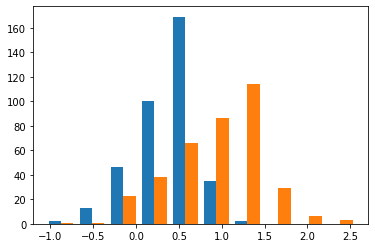

In [25]:
plt.hist(s_hat_shift)

#### Person Parameters

In [26]:
#early
early_covariance = early_model.person_parameters["covariance"]
early_mu = np.zeros(2)

#late
late_covariance = late_model.person_parameters["covariance"]
late_mu = np.concatenate((early_mu, mu_shift), axis=0)

In [27]:
def table_person_parameters(covariance, mu, latent_description=["Logic", "Iteration"], caption="", n=367):
    cov_df = pd.DataFrame(covariance)
    index = pd.MultiIndex.from_product([['Prior Competence', 'Competence Gain'], latent_description],
                        names=['Param.', 'Latent dim.'])
    cov_df.columns = index
    mu_df = pd.DataFrame(np.expand_dims(mu, axis=1), columns=[("Mean", "")])
    person_df = pd.concat((cov_df, mu_df), axis=1)
    person_df.index = index
    person_df = np.round(person_df, 3)
    print(person_df.to_latex(bold_rows=True, multicolumn=True, 
                                caption=caption+", n={0}".format(n), 
                                position="H", escape=False))
    return(person_df)
    

In [28]:
table_person_parameters(covariance=late_covariance, mu=late_mu, caption="CSEDM: Person Parameters")
# TODO: Evtl. Korrelationsmatrix mit Varianz-Spalte

\begin{table}[H]
\centering
\caption{CSEDM: Person Parameters, n=367}
\begin{tabular}{llrrrrr}
\toprule
                & \textbf{Param.} & \multicolumn{2}{l}{Prior Competence} & \multicolumn{2}{l}{Competence Gain} &   Mean \\
                & \textbf{Latent dim.} &            Logic & Iteration &           Logic & \multicolumn{2}{l}{Iteration} \\
\textbf{Param.} & \textbf{Latent dim.} &                  &           &                 &           &        \\
\midrule
\textbf{Prior Competence} & \textbf{Logic} &            1.000 &     0.284 &           0.130 &     0.071 &  0.000 \\
                & \textbf{Iteration} &            0.284 &     1.000 &           0.075 &     0.137 &  0.000 \\
\textbf{Competence Gain} & \textbf{Logic} &            0.130 &     0.075 &           0.364 &     0.107 &  0.355 \\
                & \textbf{Iteration} &            0.071 &     0.137 &           0.107 &     0.348 &  0.897 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\Jesper\AppData\Local\Temp\ipykernel_17736\1204287124.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(person_df.to_latex(bold_rows=True, multicolumn=True,


Param.                       Prior Competence           Competence Gain  \
Latent dim.                             Logic Iteration           Logic   
Param.           Latent dim.                                              
Prior Competence Logic                  1.000     0.284           0.130   
                 Iteration              0.284     1.000           0.075   
Competence Gain  Logic                  0.130     0.075           0.364   
                 Iteration              0.071     0.137           0.107   

Param.                                   Mean  
Latent dim.                  Iteration         
Param.           Latent dim.                   
Prior Competence Logic           0.071  0.000  
                 Iteration       0.137  0.000  
Competence Gain  Logic           0.107  0.355  
                 Iteration       0.348  0.897

#### Gain Visualization

In [29]:
def quantile_mean(df, metric, quantiles=[0.25, 0.5, 0.75, 1]):
    mean_df = pd.DataFrame()
    metric_quantiles = np.quantile(df[metric], quantiles)
    for quantile in metric_quantiles:
        quantile_df = df[df[metric] < quantile]
        df = df[df[metric] >= quantile]
        mean_df = pd.concat((mean_df, pd.DataFrame(quantile_df.mean()).transpose()), axis=0)
    mean_df.index = quantiles
    return(mean_df)

In [30]:
latent_df_csedm = pd.DataFrame(np.concatenate((theta_hat, s_hat_shift), axis=1))
latent_df_csedm.columns = ["prior logic", "prior iter", "logic gain", "iter gain"]

In [31]:
logic_quantile_mean = quantile_mean(latent_df_csedm, metric="prior logic")
logic_quantile_mean["post logic"] = logic_quantile_mean["prior logic"] + logic_quantile_mean["logic gain"]
logic_quantile_mean["post iter"] = logic_quantile_mean["prior iter"] + logic_quantile_mean["iter gain"]
np.round(logic_quantile_mean, 2)

,prior logic,prior iter,logic gain,iter gain,post logic,post iter
0.25,-0.99,-0.32,0.42,1.02,-0.57,0.71
0.50,-0.23,-0.03,0.33,0.84,0.10,0.81
0.75,0.32,-0.07,0.36,0.88,0.68,0.82
1.00,1.09,0.44,0.42,0.95,1.52,1.38


In [32]:
logic_quantiles = np.quantile(theta_hat[:,0], [0.25, 0.5, 0.75, 1], axis=0)
iter_quantiles = np.quantile(theta_hat[:,1], [0.25, 0.5, 0.75, 1], axis=0)

In [33]:
theta_logic_quantiles = np.split(theta_hat[np.argsort(theta_hat[:,0]), :], [10, 20])

## Model Fit

In [35]:
early_model.marginal_response_loglikelihood(U)

-5578.337926884925

In [38]:
late_model.marginal_response_loglikelihood(response_data=V, theta=theta_hat)

-4232.158225155266

## Test Set prediction
not finished

In [46]:
TEST_PATH = os.path.join("path_to_dataset/csedm_challenge_dataset/F19_Release_Test_06-28-21/test")

test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))


#Obtain Matrix of Response-vectors
test_U = pd.crosstab(index = early_test["SubjectID"], 
            columns=[early_test["AssignmentID"], early_test["ProblemID"]], 
            values=early_test["Label"],
            aggfunc="sum")